In [1]:
import pandas as pd 
import numpy as np 

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [2]:
fake = pd.read_csv('Fake.csv/Fake.csv')
true = pd.read_csv('True.csv/True.csv')

In [3]:
print('Fake News: ',fake.shape)
print('True News: ',true.shape)

Fake News:  (23481, 4)
True News:  (21417, 4)


In [4]:
#Target variable for fake news
fake['output']=0

#Target variable for true news
true['output']=1

In [5]:
#Concatenating and dropping for fake news
fake['news']=fake['title']+fake['text']
fake=fake.drop(['title', 'text'], axis=1)

#Concatenating and dropping for true news
true['news']=true['title']+true['text']
true=true.drop(['title', 'text'], axis=1)

In [6]:
fake['date'].value_counts()

May 10, 2017         46
May 26, 2016         44
May 6, 2016          44
May 5, 2016          44
May 11, 2016         43
                     ..
December 9, 2017      1
December 4, 2017      1
November 19, 2017     1
November 20, 2017     1
Jul 19, 2015          1
Name: date, Length: 1681, dtype: int64

In [7]:
fake = fake[['subject', 'date', 'news','output']]
true = true[['subject', 'date', 'news','output']]

In [8]:
#Removing links and the headline from the date column
fake=fake[~fake.date.str.contains("http")]
fake=fake[~fake.date.str.contains("HOST")]

In [9]:
fake['date'] = pd.to_datetime(fake['date'])
true['date'] = pd.to_datetime(true['date'])

In [10]:
merge = [fake, true]
df_news = pd.concat(merge)
df_news

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...,...,...
21412,worldnews,2017-08-22,'Fully committed' NATO backs new U.S. approach...,1
21413,worldnews,2017-08-22,LexisNexis withdrew two products from Chinese ...,1
21414,worldnews,2017-08-22,Minsk cultural hub becomes haven from authorit...,1
21415,worldnews,2017-08-22,Vatican upbeat on possibility of Pope Francis ...,1


In [11]:
#Creating a copy 
df_news1=df_news.copy()

In [12]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [13]:
df_news1['news']=df_news1['news'].apply(lambda x:review_cleaning(x))

In [14]:
stop = stopwords.words('english')
df_news1['news'] = df_news1['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [15]:
df_news.head()

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0


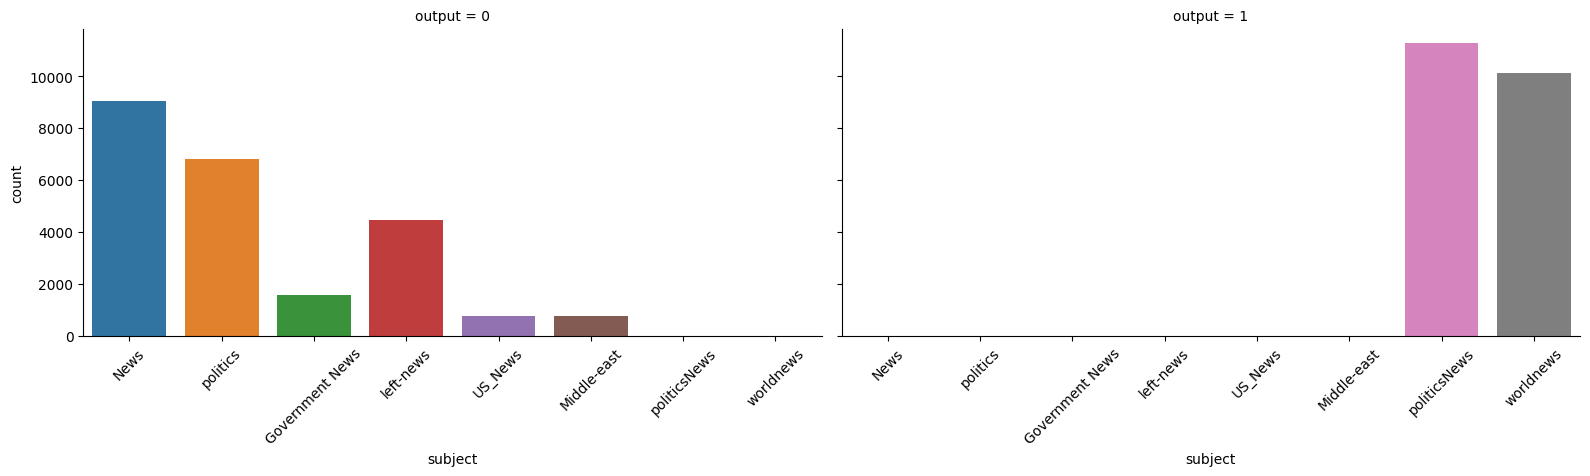

In [16]:
g = sns.catplot(x="subject", col="output",
                data=df_news1, kind="count",
                height=4, aspect=2)

#Rotating the xlabels
g.set_xticklabels(rotation=45)

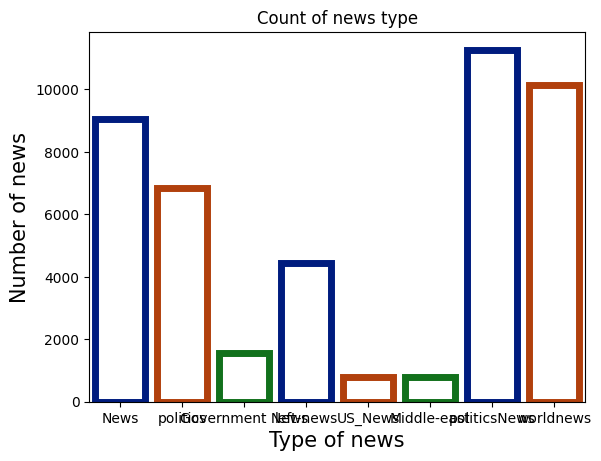

In [47]:
# Create the countplot
ax = sns.countplot(x="subject", data=df_news1,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))

# Set labels and title
ax.set(xlabel='Type of news', ylabel='Number of news', title='Count of news type')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
plt.show()


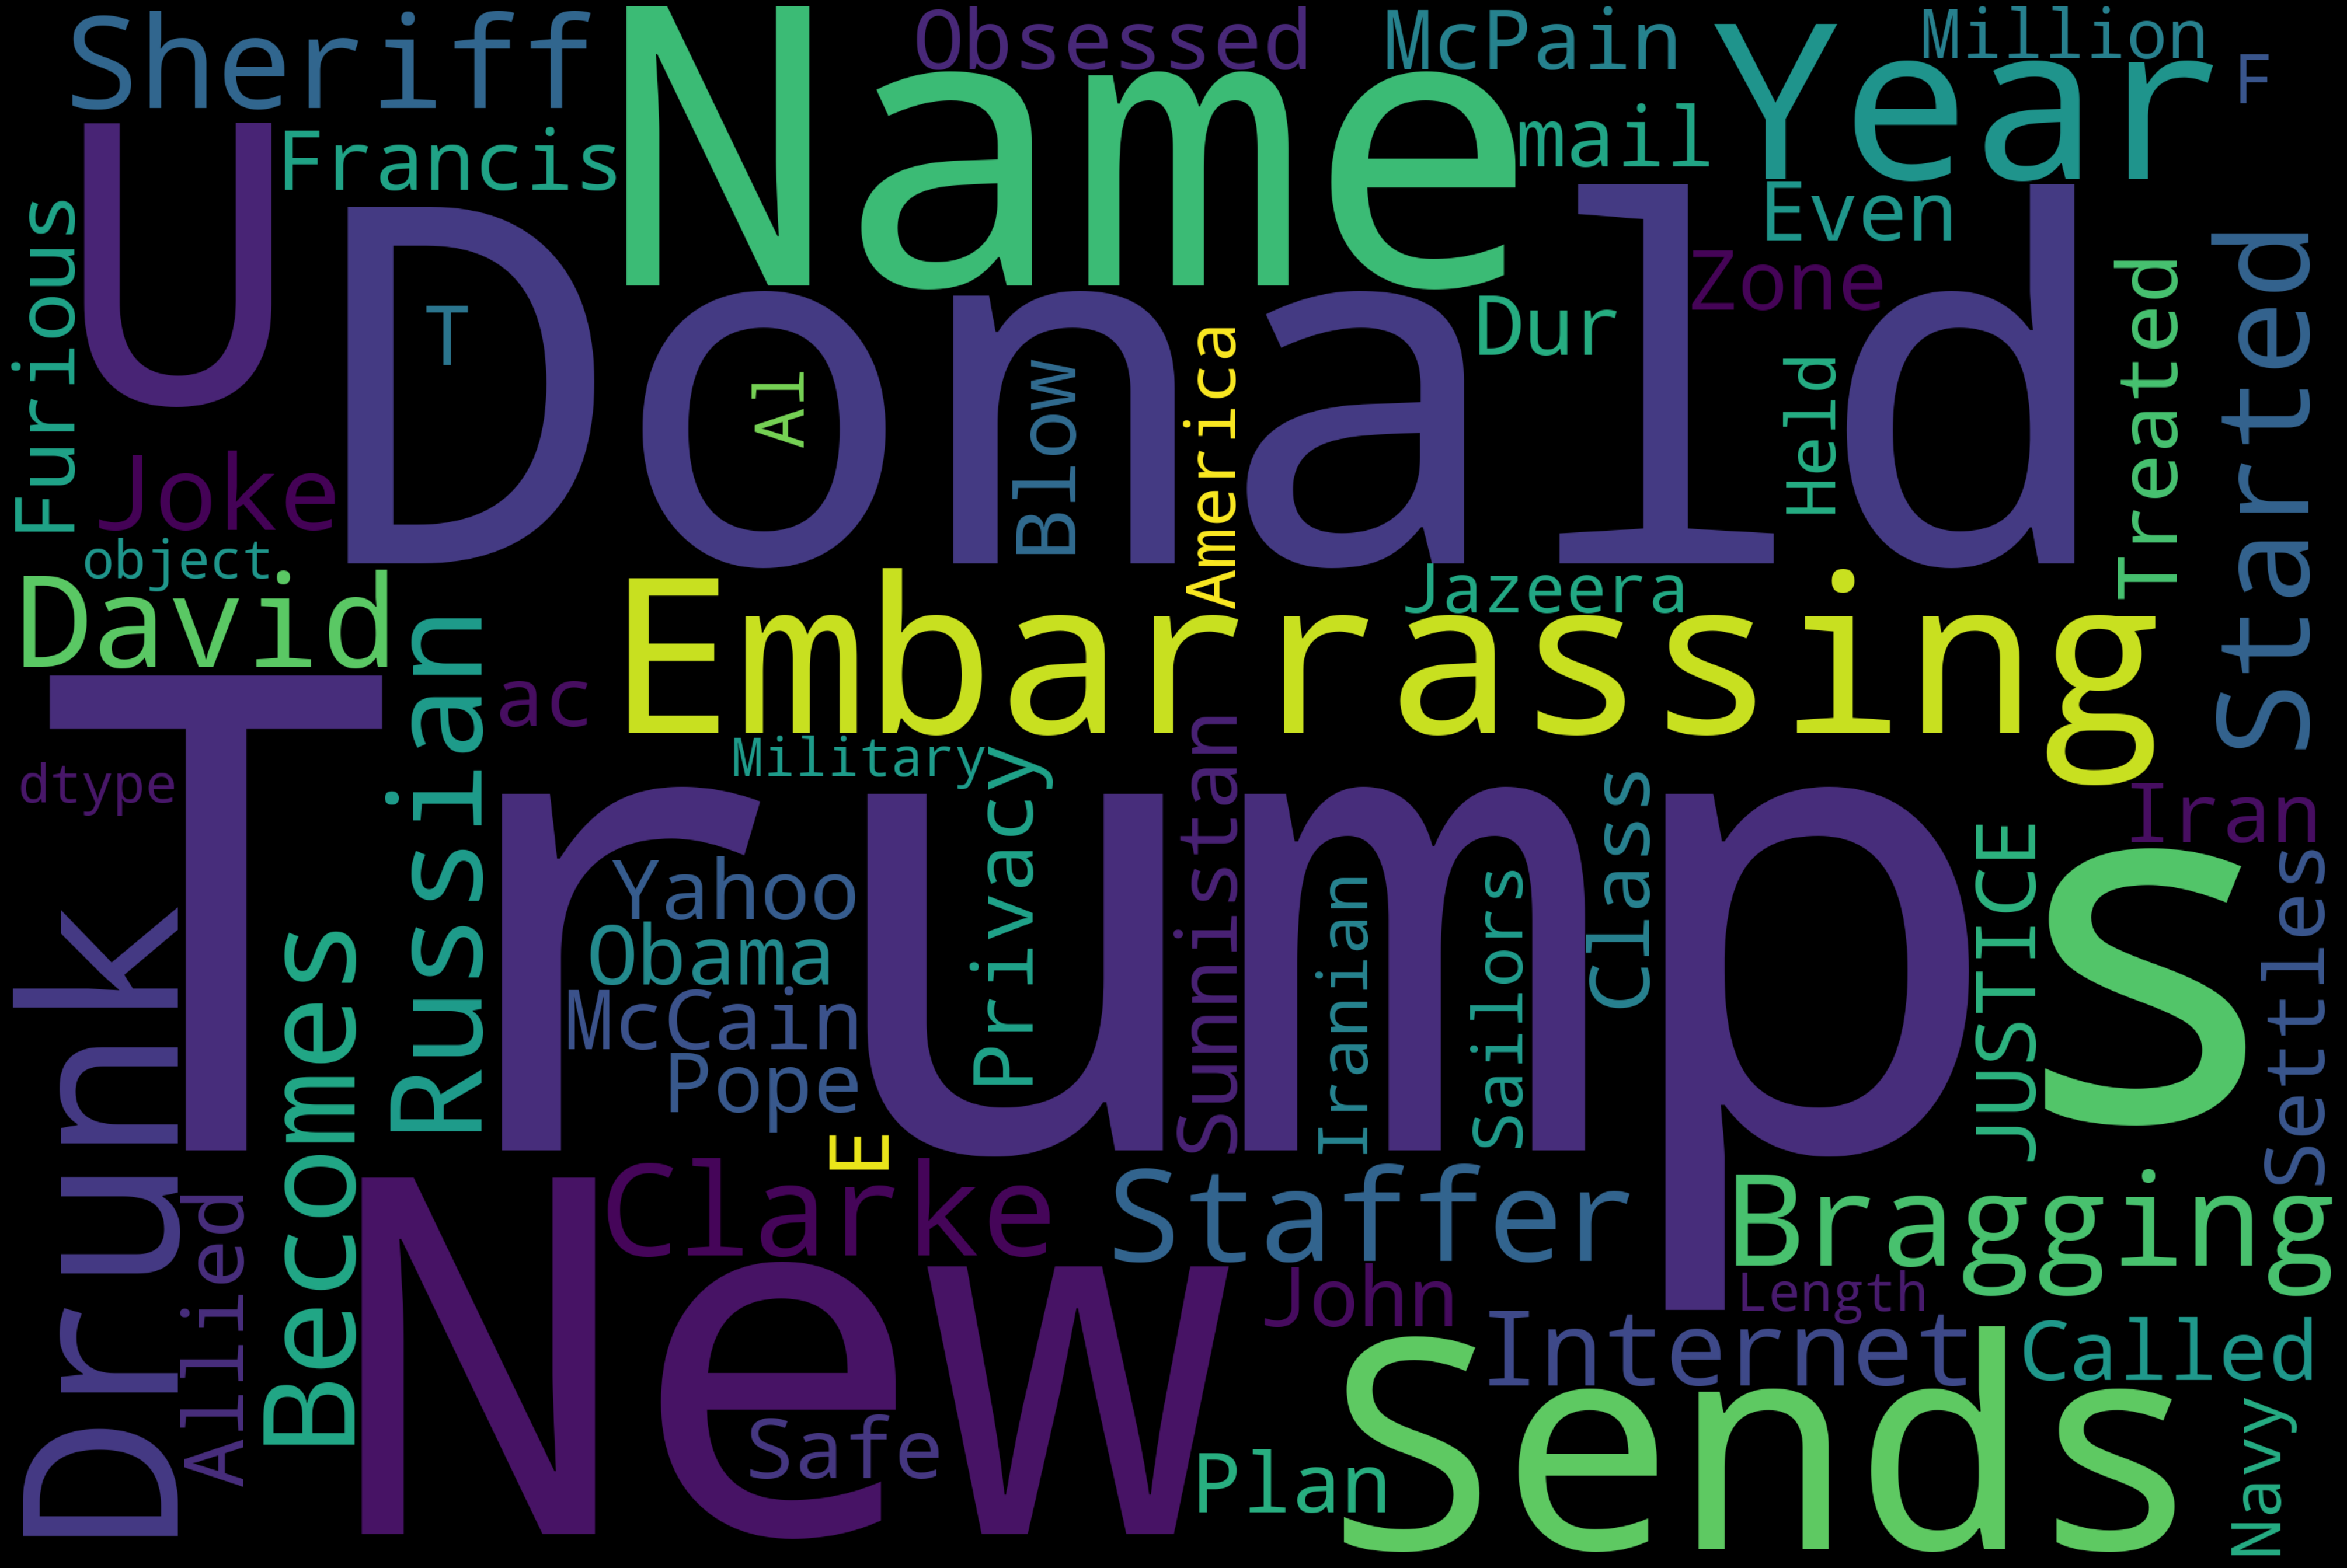

In [18]:
text = fake["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

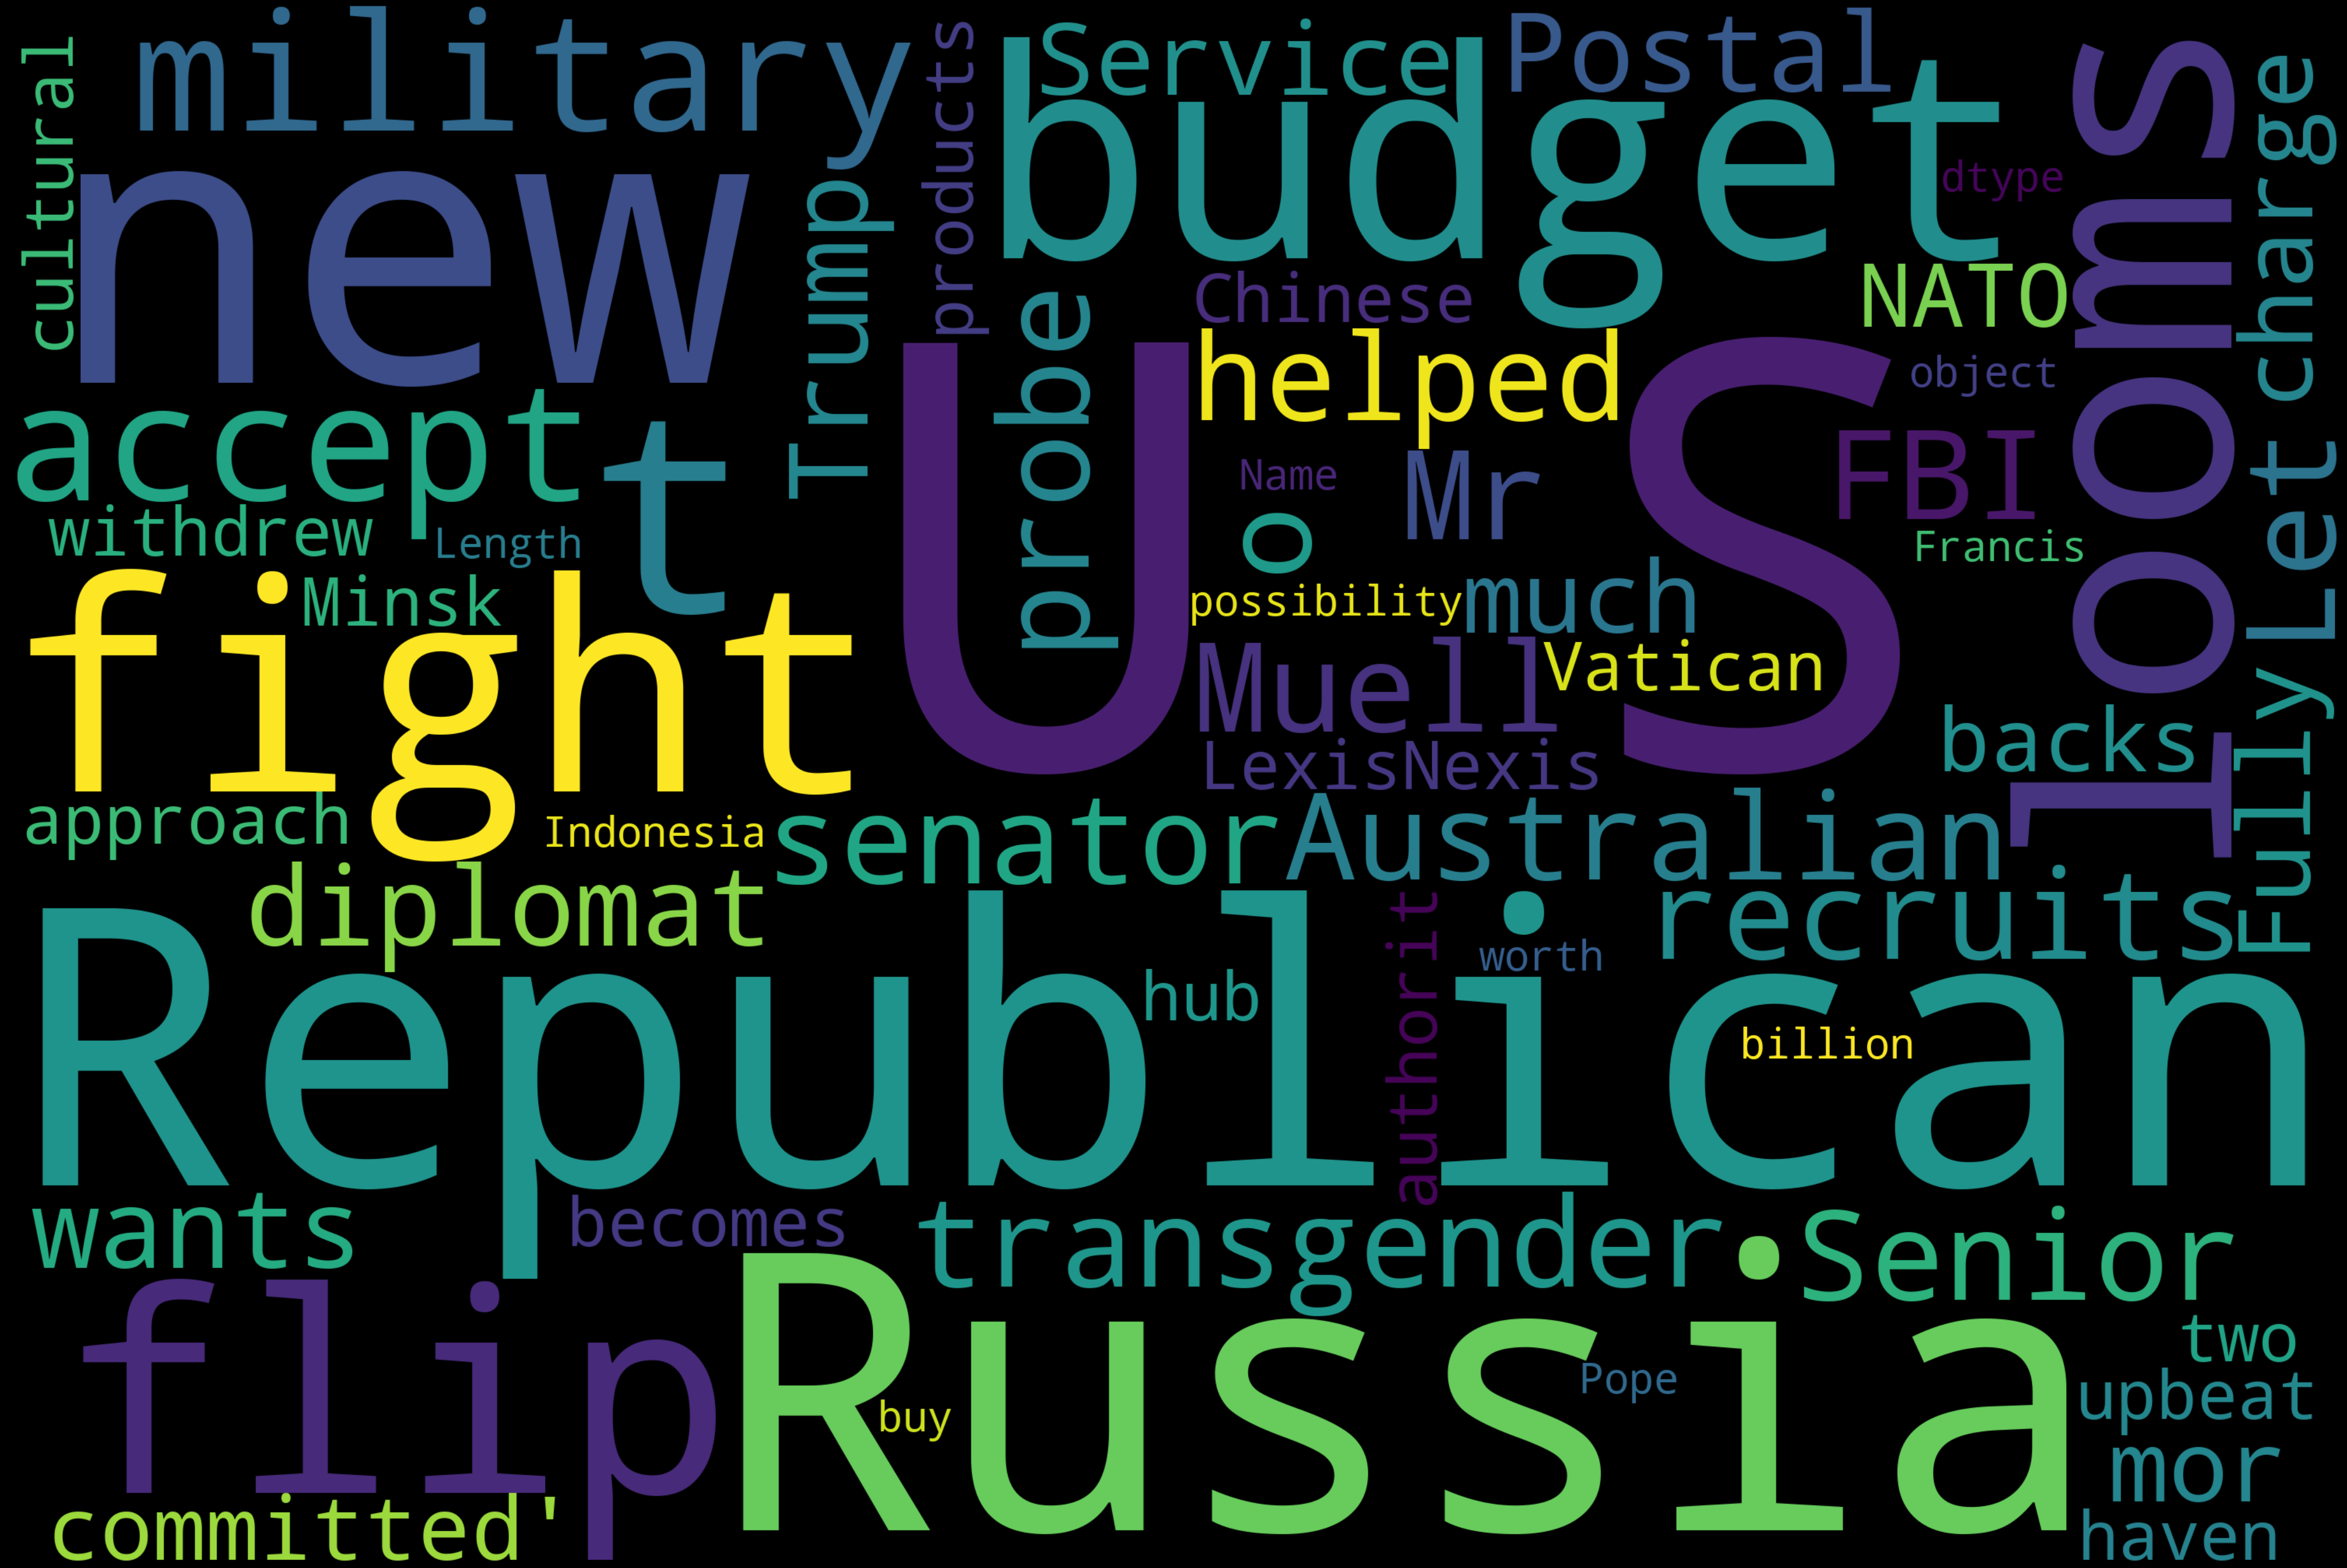

In [19]:
text = true["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [20]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Top 15 words
common_words = get_top_n_words(df_news1['news'], 15)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 15 words in news')

trump 140400
said 130258
us 68081
would 55422
president 53189
people 41718
one 36146
state 33190
new 31799
also 31209
obama 29881
clinton 29003
house 28716
government 27392
donald 27376


In [21]:
#Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 15 words
common_words = get_top_n_bigram(df_news1['news'], 15)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)
    
#Creating the dataframe of word and frequency
df3 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df3.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 15 bigrams in news')

donald trump 25059
united states 18394
white house 15485
hillary clinton 9502
new york 8110
north korea 7053
president donald 6928
image via 6188
barack obama 5603
trump said 4816
prime minister 4753
president trump 4646
supreme court 4595
last year 4560
last week 4512


In [22]:
#Function to get top trigram words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 15 words
common_words = get_top_n_trigram(df_news1['news'], 15)

#Printing word and their respective frequencies
for word, freq in common_words:
    print(word, freq)

#Creating a dataframe with words and count
df6 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Grouping the words and plotting their frequencies
df6.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 15 trigrams in news')

president donald trump 6808
president barack obama 3735
new york times 2034
donald trump realdonaldtrump 1790
reuters president donald 1476
black lives matter 1436
president united states 1096
white house said 1050
presidentelect donald trump 1043
new york city 1006
president vladimir putin 955
news century wire 951
national security adviser 898
affordable care act 868
director james comey 860


In [23]:
#Extracting 'reviews' for processing
news_features=df_news1.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

,news
0,donald trump sends embarrassing new year’s eve...
1,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes internet joke thr...
3,trump obsessed even obama’s name coded website...
4,pope francis called donald trump christmas spe...


In [24]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)   

In [25]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

In [26]:
y=df_news1['output']

In [27]:
#Setting up vocabulary size
voc_size=10000

#One hot encoding 
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [28]:
#Setting sentence length
sent_length=5000

#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 5890  447 7360]
 [   0    0    0 ... 5618 4395 7360]
 [   0    0    0 ... 5111 3352 7360]
 ...
 [   0    0    0 ... 2524 8114 6678]
 [   0    0    0 ...  347 9803 6884]
 [   0    0    0 ... 2868 1041 6090]]


In [29]:
embedded_docs[1]

array([   0,    0,    0, ..., 5618, 4395, 7360])

In [30]:
#Creating the lstm model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(50)) #Adding 50 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 40)          400000    
                                                                 
 dropout (Dropout)           (None, 5000, 40)          0         
                                                                 
 lstm (LSTM)                 (None, 50)                18200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 418,251
Trainable params: 418,251
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
len(embedded_docs),y.shape

(44888, (44888,))

In [32]:
# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((44888, 5000), (44888,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=42)

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=1,batch_size=64)

527/527 [==============================] - 3983s 8s/step - loss: 0.2561 - accuracy: 0.9097 - val_loss: 0.1410 - val_accuracy: 0.9570


351/351 [==============================] - 398s 1s/step


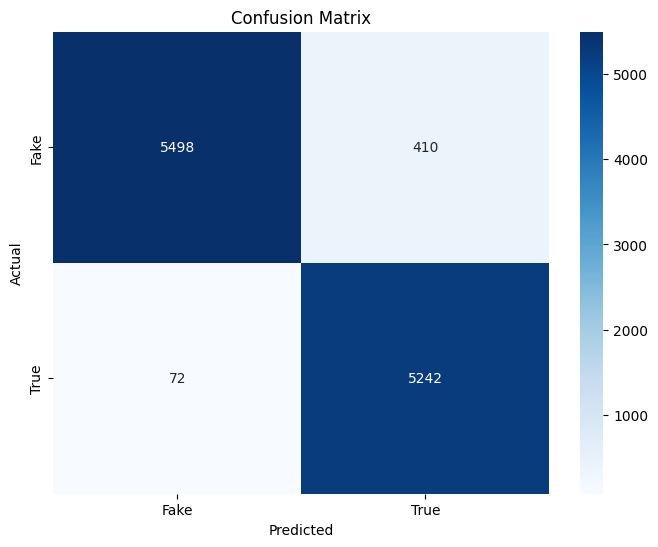

In [26]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Predicting probabilities from test dataset
y_pred_probs = model.predict(X_test)

# Rounding predicted probabilities to get predicted classes
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_classes)
plot_confusion_matrix(cm, classes=['Fake', 'True'])

In [27]:
#Calculating Accuracy score
accuracy_score(y_test,y_pred_classes)

0.9570486544288006

In [28]:
print(classification_report(y_test,y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      5908
           1       0.93      0.99      0.96      5314

    accuracy                           0.96     11222
   macro avg       0.96      0.96      0.96     11222
weighted avg       0.96      0.96      0.96     11222



In [29]:
from tensorflow.keras.models import load_model
import joblib

# Save the trained model
model.save('fake_news_model1.h5')

# Prediction

In [49]:
# Take user input
user_input = input("Enter a news text: ")

# Preprocess the user input
cleaned_input = review_cleaning(user_input)
stemmed_input = [ps.stem(word) for word in cleaned_input.split() if not word in stop_words]
input_corpus = ' '.join(stemmed_input)
input_onehot_repr = [one_hot(input_corpus, voc_size)]
input_padded = pad_sequences(input_onehot_repr, padding='pre', maxlen=sent_length)

# Predict using the trained model
prediction = model.predict(input_padded)

# Print prediction result
predicted_class = "True" if prediction[0][0] < 0.5 else "Fake"
predicted_proba = prediction[0][0] if predicted_class == "False" else 1 - prediction[0][0]

print(f"Predicted Class: {predicted_class}")
print(f"Probability of Predicted Class: {predicted_proba:.4f}")

# Print the result
if prediction[0][0] < 0.5:
    print("The input news is classified as True.")
else:
    print("The input news is classified as False.")


Enter a news text: Trump says Russia probe will be fair, but timeline unclear: NYT
1/1 [==============================] - 0s 445ms/step
Predicted Class: True
Probability of Predicted Class: 0.7481
The input news is classified as True.
